# 1.Librerias y funcion para la conexion

In [42]:
#Instalo el reportlab para imprimir los graficos por pdf
!pip install reportlab
print("EXITO")

EXITO


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from pprint import pprint
import numpy
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas

def descargarPagina(url):
    # Realizamos la petición a la web
    req = requests.get(url)

    # Comprobamos que la petición nos devuelve un Status Code = 200
    statusCode = req.status_code
    # la petición ha ido bien
    if statusCode == 200:   
        # Pasamos el contenido HTML de la web a un objeto BeautifulSoup()
        soup = BeautifulSoup(req.text,"html.parser")
        return True, soup
    
    # la petición ha ido mal     
    else:   
        return False, "ERROR {}".format(statusCode)
print("EXITO")

EXITO


# 2.Configurador 

In [2]:
#Configurar para la busqueda
TipoScan = "viviendas"
CiudadScan = "madrid"
PrecioMin = 70000 #Recomendado >=70000
PrecioMax = 50000000 #Recomendado <=1000000
MetrosMin = 40 #Recomendado >=70
MetrosMax = 30000 #Recomendado <=300
PERMin = 5 #Recomendado =5
PERMax = 2000 #Recomendado =20

#Cuento los caracteres del nombre de la ciudad
CaracteresCiudad = len(CiudadScan)+3
print("EXITO")

EXITO


# 3.Conexion a Habitaclia
Url de la pagina https://www.habitaclia.com/viviendas-madrid.htm

In [3]:
url = 'https://www.habitaclia.com/'+TipoScan+'-'+CiudadScan+'-'+'0'+'.htm' 
status, sopa = descargarPagina(url) #Funcion creada arriba 
if status:
    print("Descargando de: " + url)
else:
    print(sopa)

#Buscamos el numero de paginas que tiene la web   
Pag = sopa.find('div', {'class' : 'w-100 bg-white margin-y pagination'}).find('ul', {'class' : 'f-right'}).find_all('li')
for i,a in enumerate(Pag):
    if (i == 5):
        NumPaginas = int(a.select_one('a').text)
        print(f"Paginas para Scrapear: "+str(NumPaginas))
        break
print("EXITO")

Descargando de: https://www.habitaclia.com/viviendas-madrid-0.htm
Paginas para Scrapear: 911
EXITO


# 4. CARGO EL EXCEL EN UN DATAFRAME

La informacion del excel que cargamos corresponde al mes de abril. Podemos entrar al siguiente link para actualizar la informacion.

Datos auxiliares: https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/alquiler/madrid-comunidad/madrid-provincia/madrid/

In [7]:
dfAlquiler = pd.read_excel('AuxDatosTFM.xlsx', sheet_name = "ALQUILER", index_col=0)
dfVenta = pd.read_excel('AuxDatosTFM.xlsx', sheet_name = "VENTA", index_col=0)

In [4]:
dfAlquiler.columns

Index(['Precio_m2_abr_2023', 'Variación_mensual', 'Variación_trimestral',
       'Variación_anual', 'Máximo_histórico', 'Variación_máximo'],
      dtype='object')

In [8]:
dfVenta.columns

Index(['Precio_m2_abr_2023', 'Variación_mensual', 'Variación_trimestral',
       'Variación_anual', 'Máximo_histórico', 'Variación_máximo'],
      dtype='object')

# 5.Funciones para procesar el dato

In [4]:
def PrecioMedioBarrioComprar(Barrio):
    #Vuelco el excel en un dataframe y leo las columnas A Y B de la hoja Alquiler
    dfVenta = pd.read_excel('AuxDatosTFM.xlsx', sheet_name='VENTA', usecols='A:C')
    
    #Busco el barrio en el Excel
    FiltroPorBarrio = dfVenta[dfVenta["Localización"] == Barrio]
    
    #Si el dataframe esta vacio, imprime el error
    if FiltroPorBarrio.empty:
        return False, -1
    else:
        #Reindexo el dataframe
        FiltroPorBarrio = FiltroPorBarrio.reset_index(drop=True)
        #Recogo el precio del barrio y le limpio el punto y el €/m2
        PrecioDelBarrioCompSinFiltrar = FiltroPorBarrio.iloc[0, 2].replace(".", "")
        PrecioDelBarrioComp = float(PrecioDelBarrioCompSinFiltrar[:-4])
        return True, PrecioDelBarrioComp



def PrecioMedioBarrioAlquiler(Barrio):
    #Vuelco el excel en un dataframe y leo las columnas A Y B de la hoja Alquiler
    dfAlquiler = pd.read_excel('AuxDatosTFM.xlsx', sheet_name='ALQUILER', usecols='A:C')
    
    #Busco el barrio en el Excel
    FiltroPorBarrio = dfAlquiler[dfAlquiler["Localización"] == Barrio]

    #Si el dataframe esta vacio, imprime el error
    if FiltroPorBarrio.empty:
        return False, -1
    else:
        #Reindexo el dataframe
        FiltroPorBarrio = FiltroPorBarrio.reset_index(drop=True)
        #Recogo el precio del barrio y le limpio el punto y el €/m2
        PrecioDelBarrioCompSinFiltrar = FiltroPorBarrio.iloc[0, 2].replace(",", ".")
        PrecioDelBarrioAlq = float(PrecioDelBarrioCompSinFiltrar[:-4])
        return True, PrecioDelBarrioAlq



def CalculoPer(Precio, Metros, PrecioMedAlq):
    if(PrecioMedAlq != -1):
        PrecioMedAlqTotal = Metros*PrecioMedAlq
        PER = round((Precio/PrecioMedAlqTotal)/12, 2)
        return PER
    else:
        #ContadorPisosSinInfoAux += 1
        return -1


print("EXITO")

EXITO


# 6.Bajar el dato de la Pagina

In [6]:
#Creamos las listas donde se guardaran la informacion de cada anuncio scrapeado
lsTitulo = []
lsBarrio = []
lsMetros = []
lsPrecio = []
lsPrecioM2 = []
lsPrecioMedComp = []
lsPrecioMedAlq = []
lsPER = []
lsLink = []

#Almacenamos el numero de pisos que hemos guardado
ContadorPisos = 0
ContadorPisosSinAlgunDato = 0
ContadorPaginas = 0
ContadorPisosIncluidos = 0
ContadorPisosExcluidos = 0
#ContadorPisosSinInfoAux = 0


#SCRAPEA DATOS
#Recorro las paginas de la web
for a in range(NumPaginas):
    url = 'https://www.habitaclia.com/'+TipoScan+'-'+CiudadScan+'-'+str(a)+'.htm' 
    status, sopa = descargarPagina(url) #Funcion creada arriba 
    
    if status:
        #Recojo los anuncios de esa pagina en la que me encuentro
        pisos = sopa.find_all('div', {'class' : 'list-item-info'})
        
        #Itero sobre los anuncios de la pagina
        for i,lib in enumerate(pisos[:15]):
            #Compruebo que el anuncio tiene el dato
            Titulo = lib.find("h3").find('a')
            LinkTitulo = lib.find("h3", {'class' : 'list-item-title'}).find('a')
            BarrioSinFiltro = lib.find("p", {'class' : 'list-item-location'}).find('span')
            MetrosSinFiltro = lib.find("p", {'class' : 'list-item-feature'})
            PrecioSinFiltro = lib.find('article', {'class' : 'list-item-price'}).find('span', {'class': 'font-2'})
            
            #Si el anuncio tiene todos los datos, los recojo
            if((Titulo != None) and (BarrioSinFiltro != None) and (MetrosSinFiltro != None) and (PrecioSinFiltro != None) and (LinkTitulo != None)):
                ContadorPisos += 1
                
                '''
                Titulo = Titulo.get('title')
                LinkTitulo = LinkTitulo.get('href')
                BarrioSinFiltro = BarrioSinFiltro.text
                MetrosSinFiltro = MetrosSinFiltro.text
                PrecioSinFiltro = PrecioSinFiltro.text
                '''
                
                #Recojemos los datos
                Titulo = lib.find("h3").find('a').get('title')
                LinkTitulo = lib.find("h3", {'class' : 'list-item-title'}).find('a').get('href')
                BarrioSinFiltro = lib.find("p", {'class' : 'list-item-location'}).find('span').text
                MetrosSinFiltro = lib.find("p", {'class' : 'list-item-feature'}).text
                PrecioSinFiltro = lib.find('article', {'class' : 'list-item-price'}).find('span', {'class': 'font-2'}).text
                
                #LIMPIAMOS DATOS
                #Limpia el nombre de la ciudad para el barrio
                Barrio = BarrioSinFiltro[CaracteresCiudad:]
                
                #Limpia los metros de metros cuadrados
                Metros= float(MetrosSinFiltro[:MetrosSinFiltro.find("m")].replace(".", ""))
                
                #Limpio Precio
                PrecioConPunto = PrecioSinFiltro[:-2]
                Precio = float(PrecioConPunto.replace(".", ""))
            
                #Calcula el precio del metro cuadrado
                PrecioM2 = round(Precio / Metros)
                
                #Precio medio del Barrio para comprar
                PrecioMedCompExiste, PrecioMedComp = PrecioMedioBarrioComprar(Barrio)
                #Precio medio del Barrio para alquilar
                PrecioMedAlqExiste, PrecioMedAlq = PrecioMedioBarrioAlquiler(Barrio)
                    
                #Calcular PER
                PER = CalculoPer(Precio, Metros, PrecioMedAlq)
                    
                if((Precio >= PrecioMin) and (Precio <= PrecioMax) and (Metros >= MetrosMin) and (Metros <= MetrosMax) and (PER >= PERMin) and (PER <= PERMax)):
                            
                    ContadorPisosIncluidos += 1
                                
                    lsTitulo.append(Titulo)
                    lsBarrio.append(Barrio)
                    lsMetros.append(Metros)
                    lsPrecio.append(Precio)
                    lsPrecioM2.append(PrecioM2)
                    lsPrecioMedComp.append(PrecioMedComp)
                    lsPrecioMedAlq.append(PrecioMedAlq)
                    lsPER.append(PER)
                    lsLink.append(LinkTitulo)
                    #print(f"Piso {i+1}: {Titulo} -- {Barrio} -- {Metros}m2 -- {Precio}€ -- {PrecioM2}€ -- {PrecioMedComp}€ -- {PrecioMedAlq}€ -- {PER}€ -- {LinkTitulo} \n")
                                
                else:
                    ContadorPisosExcluidos += 1
            else:
                ContadorPisosSinAlgunDato += 1
        
        #Para que solo itere las paginas que quiera            
        #if(ContadorPaginas == 10):
            #break
            
        
        ContadorPaginas += 1    
        print("Pagina: "+ str(ContadorPaginas))    
        print("---------------------------")
        
    else:
        print(sopa)
        

print(f'\nHay: '+str(ContadorPisos)+' pisos en esta página')
print(f'Pisos sin algun dato: '+str(ContadorPisosSinAlgunDato))
print(f'Pisos Incluidos: '+str(ContadorPisosIncluidos))
print(f'Pisos Excluidos: '+str(ContadorPisosExcluidos))
#print(f'No se puede calcular: '+str(ContadorPisosSinInfoAux))

Pagina: 1
---------------------------


UnboundLocalError: local variable 'ContadorPisosSinInfoAux' referenced before assignment

# 7.Exportar el dataframe a Excel

In [23]:
# CREA EL EXCEL Y EL DATAFRAME
# Crea un DataFrame de pandas con los datos
df = pd.DataFrame({
    'Titulo': lsTitulo,
    'Barrio': lsBarrio,
    'Metros': lsMetros,
    'Precio': lsPrecio,
    'PrecioM2(Precio/Metros)': lsPrecioM2,
    'PrecioMedCompPorM2DelBarrio': lsPrecioMedComp,
    'PrecioMedAlqPorM2DelBarrio': lsPrecioMedAlq,
    'PER': lsPER,
    'Link': lsLink
})

# Guarda el DataFrame en un archivo Excel
df.to_excel('DatosDescargados.xlsx', index=False)
print("EXITO") 

EXITO


In [ ]:
#Al recoger del excel pasar a lower y quitar acentos
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        (" ", ""),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())

In [ ]:
#Poner la linea de la media de todos(madrid)
#Agrupar por distrito con la tabla Aux
#Histogramas barras agrupadas precio, metros...

# 8.Imprimir Graficos

PER medio de madrid: 15.004
Barrio
Abrantes             13.436429
Acacias              17.549118
Adelfas              16.752857
Alameda de Osuna     19.253333
Almagro              14.185000
Almenara-Ventilla    14.623333
Almendrales          13.405882
Aluche               16.485667
Ambroz               13.726429
Apóstol Santiago     16.948889
Arapiles             16.892000
Aravaca              14.150000
Arcos                14.993571
Argüelles            15.483333
Name: PER, dtype: float64


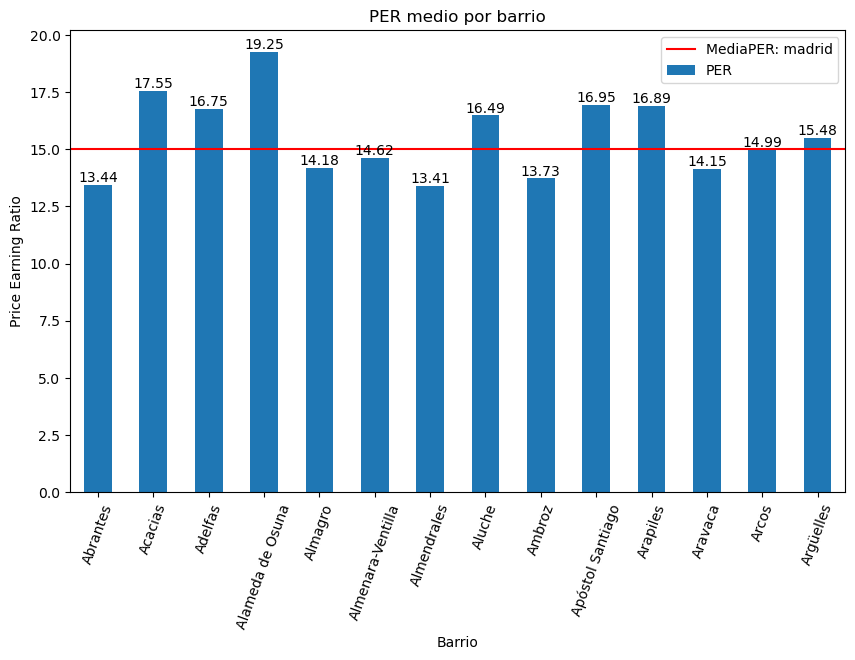

PER medio de madrid: 15.004
Barrio
Bellas Vistas                  16.278182
Berruguete                     16.707632
Buena Vista                    13.835909
Butarque                       16.037778
Canillas                       16.787857
Canillejas                     16.542857
Casco Histórico de Barajas     16.148500
Casco Histórico de Vallecas    13.445532
Castilla                       17.820000
Castillejos-Cuzco              17.022222
Chopera                        18.507000
Ciudad Jardín                  17.740000
Ciudad Universitaria            9.626154
Colina                         17.770000
Name: PER, dtype: float64


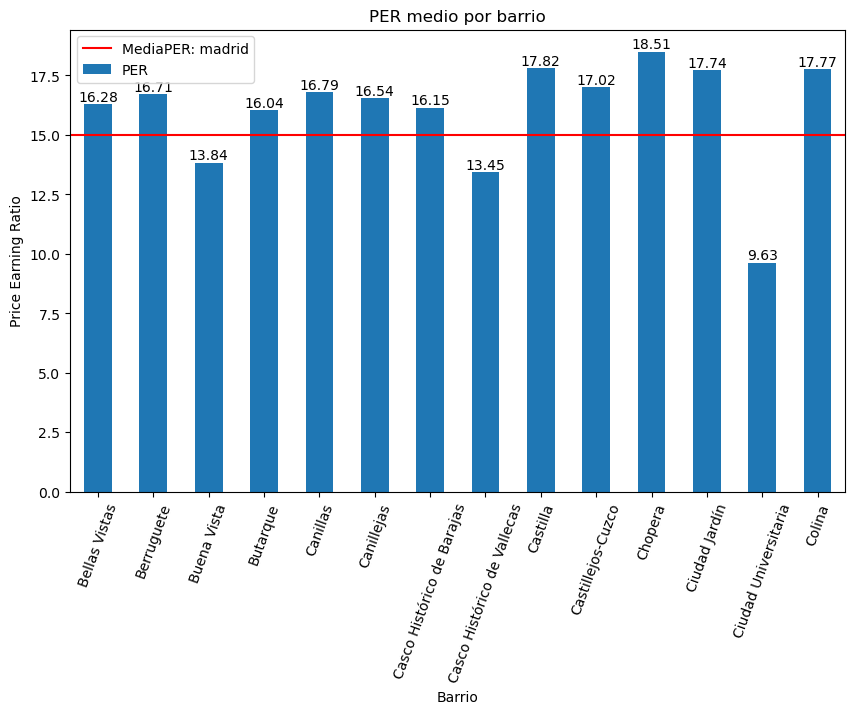

PER medio de madrid: 15.004
Barrio
Comillas                            16.263768
Concepción                          17.650588
Corralejos-Campo de las Naciones    15.155000
Cortes-Huertas                      13.651053
Costillares                         16.700000
Cuatro Caminos - Azca               15.100000
Delicias                            18.524074
El Cañaveral-Los Berrocales         15.757778
El Viso                             18.821429
Embajadores-Lavapiés                16.987397
Ensanche de Vallecas-La Gavia       16.941333
Estrella                             8.810000
Fuente del Berro                    17.350000
Gaztambide                          17.377500
Name: PER, dtype: float64


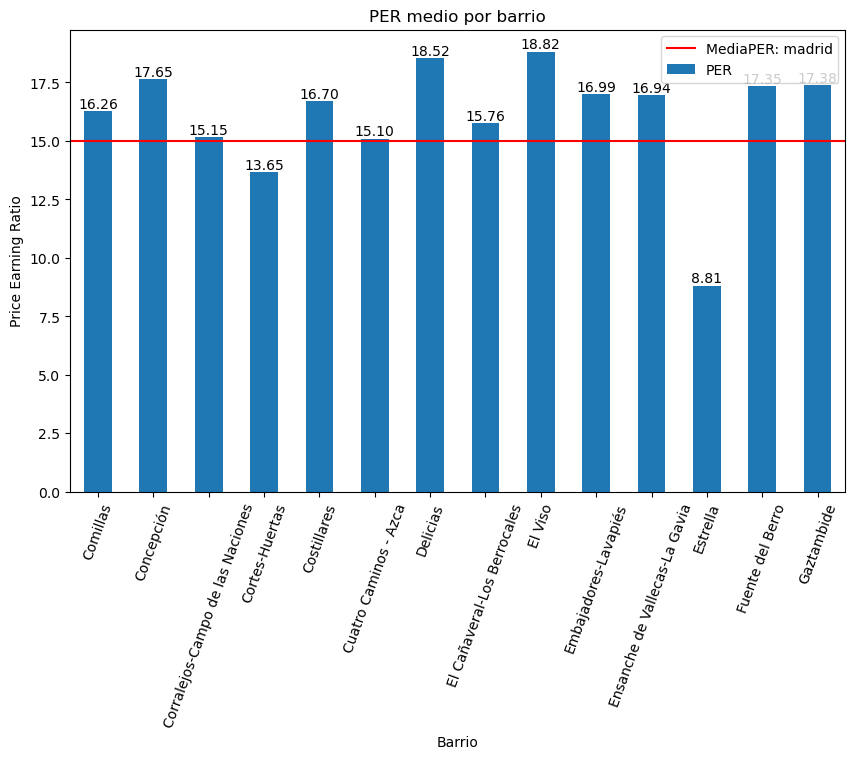

PER medio de madrid: 15.004
Barrio
Goya                       18.586000
Guindalera                 16.241081
Hispanoamérica-Bernabéu    17.270000
Ibiza                      18.298000
Imperial                   17.528261
Jerónimos                  11.720000
Justicia-Chueca            15.123333
Las Tablas                 18.616667
Legazpi                    15.125000
Lista                      18.733333
Los Rosales                12.907708
Los Ángeles                14.929744
Lucero                     15.316042
Marroquina                 17.398000
Name: PER, dtype: float64


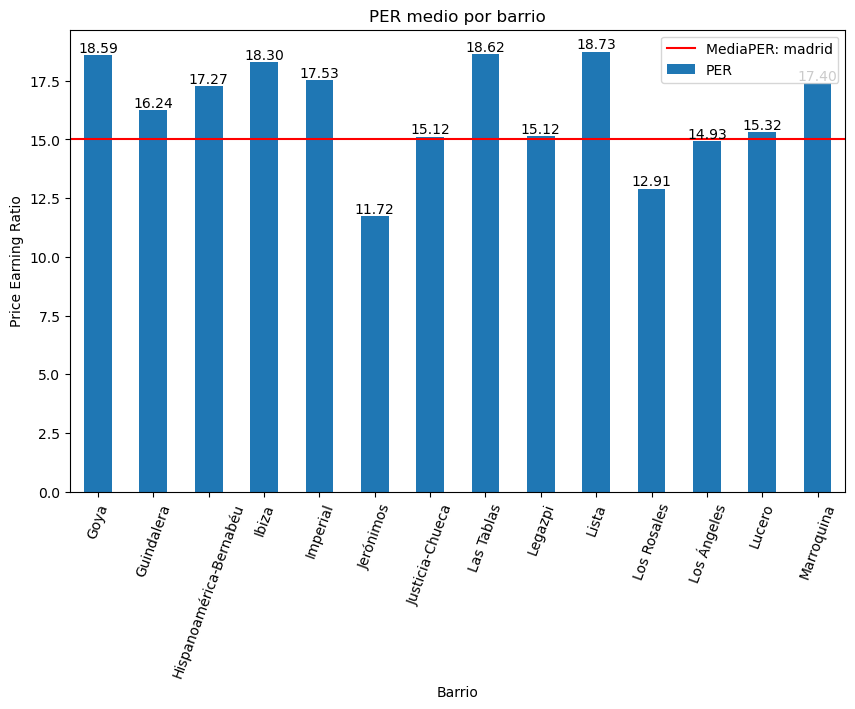

PER medio de madrid: 15.004
Barrio
Montecarmelo             19.350000
Moscardó                 16.386818
Niño Jesús               15.226667
Numancia                 12.582308
Opañel                   12.938333
Orcasur-12 de Octubre    12.213333
Pacífico                 17.931538
Palacio                  17.820833
Palomeras Bajas          14.874138
Palomeras Sureste        14.560286
Palos de Moguer          18.187200
Pau de Carabanchel       16.085833
Peñagrande               17.768235
Pilar                    14.967692
Name: PER, dtype: float64


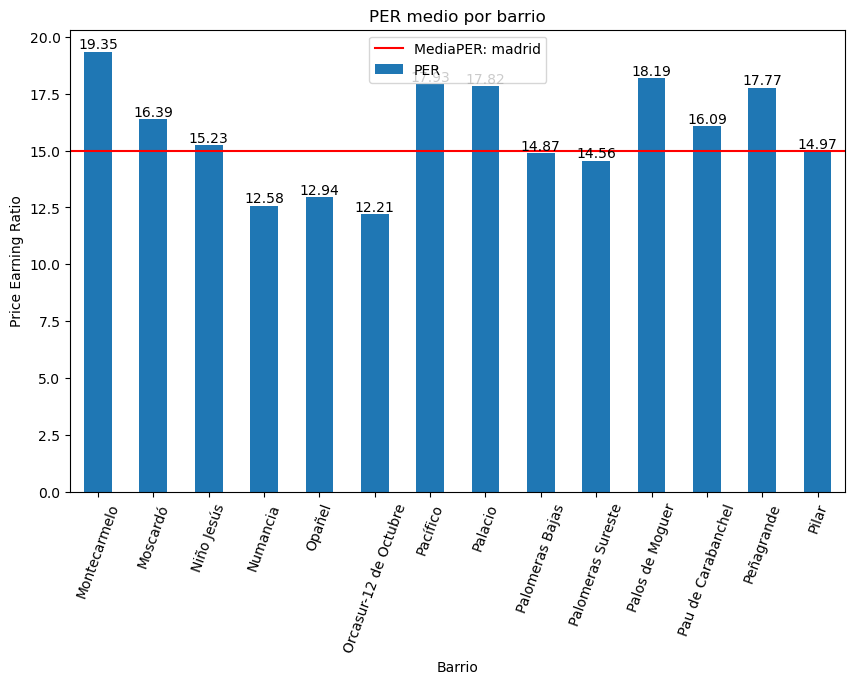

PER medio de madrid: 15.004
Barrio
Pinar del Rey                    16.775833
Portazgo                         11.716667
Pradolongo                       12.240800
Prosperidad                      16.340000
Pueblo Nuevo                     15.445699
Puerta Bonita                    13.181565
Puerta del Ángel                 14.547838
Quintana                         15.600000
Recoletos                        19.900000
Rosas - Musas                    18.021500
Ríos Rosas-Nuevos Ministerios    15.825714
Salvador                         18.587143
San Andrés                       12.688681
San Diego                        10.950309
Name: PER, dtype: float64


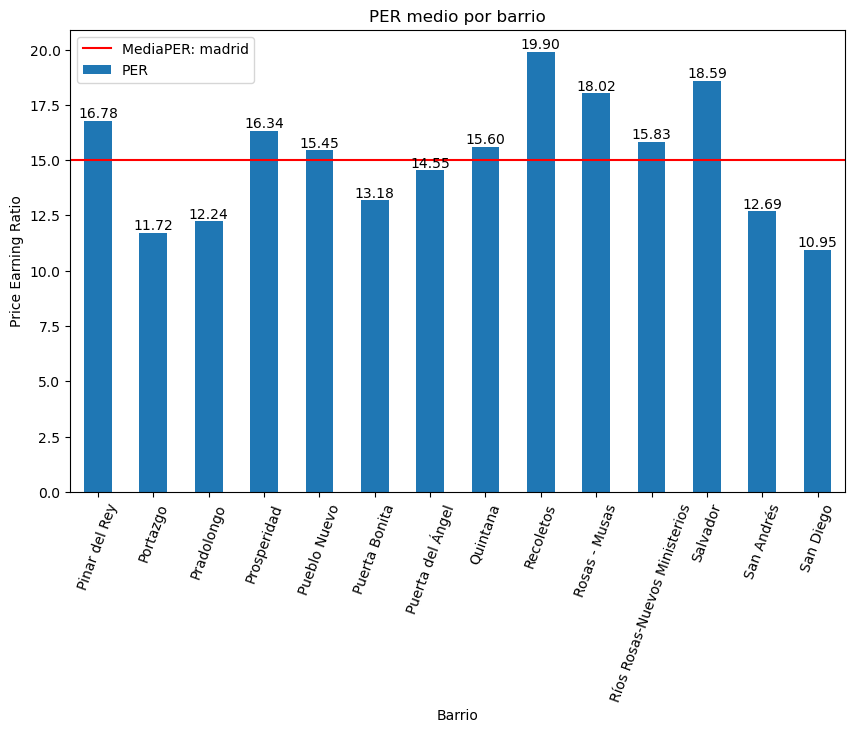

PER medio de madrid: 15.004
Barrio
San Fermín                   15.060000
San Isidro                   14.284107
San Pascual                  16.125000
Sanchinarro                  18.020000
Simancas                     14.892128
Sol                          11.953158
Trafalgar                    16.035714
Tres Olivos-Valverde         15.485938
Universidad-Malasaña         16.301905
Valdeacederas                15.582778
Valdebebas - Valdefuentes    11.540000
Valdebernardo-Valderribas    17.576000
Valdemarín                   19.050000
Valdezarza                   15.536000
Name: PER, dtype: float64


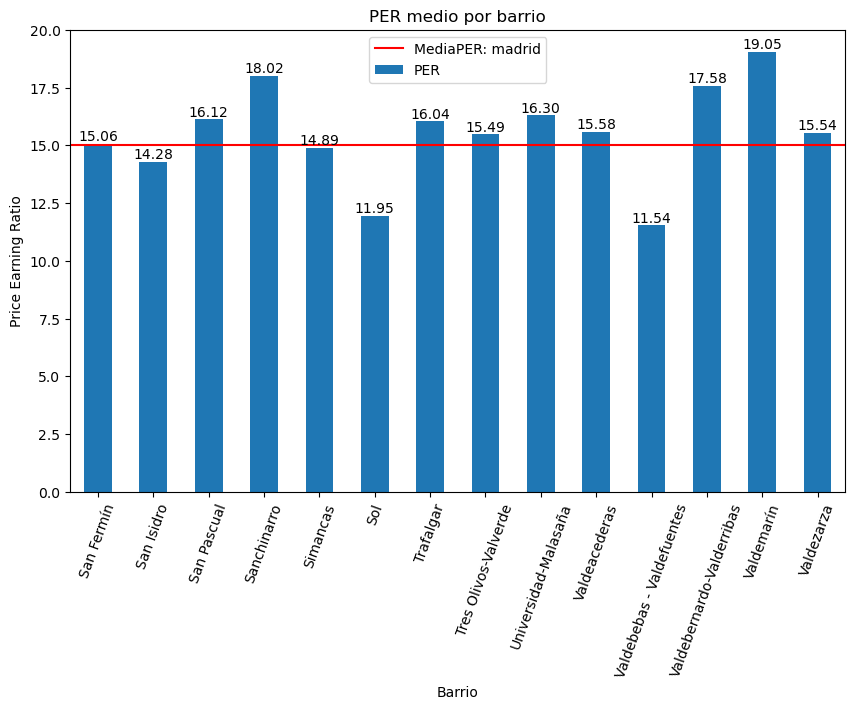

PER medio de madrid: 15.004
Barrio
Vallehermoso                    18.085000
Ventas                          15.134800
Vinateros                       17.927500
Virgen del Cortijo-Manoteras    17.913158
Vista Alegre                    13.844231
Zofío                           12.244545
Name: PER, dtype: float64


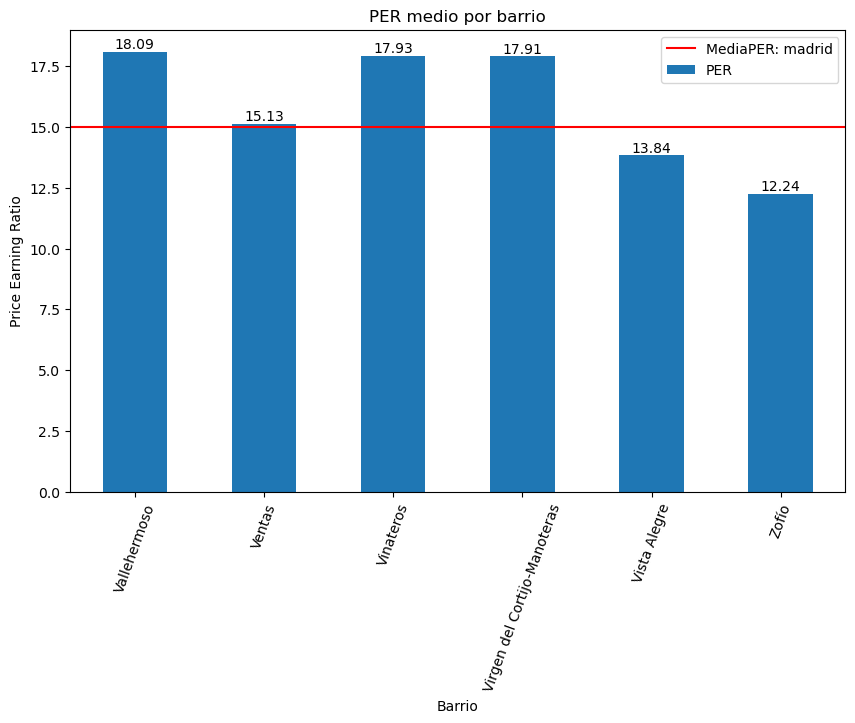

Se ha guardado el gráfico en el archivo 'AnalisisPER.pdf'.


In [50]:
#Eliminar las filas con precio igual a -1
dfFiltrado = df[df['PER'] != -1]

MediaPER = dfFiltrado['PER'].mean()

#Agrupar por barrio y calcular el precio medio
PERMedioBarrio = dfFiltrado.groupby('Barrio')['PER'].mean()

#Dividir la lista de barrios en grupos de 14
NumBarras = 14
AgrupadoBarrios = [PERMedioBarrio[i:i+NumBarras] for i in range(0, len(PERMedioBarrio), NumBarras)]

#Crear un archivo PDF
FicheroPDF = 'AnalisisPER.pdf'
#Crea un objeto Canvas
c = canvas.Canvas(FicheroPDF)

# Posición inicial para el primer gráfico
x_pos = 50
y_pos = 750

# Imprimir los grupos de barrios
for Barrio in AgrupadoBarrios:
    print(f'PER medio de '+CiudadScan+': '+str(round(MediaPER,3)))
    print(Barrio)

    # Crear un gráfico de barras con el precio medio por barrio en el grupo actual
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico (opcional)
    ax = Barrio.plot(kind='bar')
    plt.title('PER medio por barrio')
    plt.xlabel('Barrio')
    plt.ylabel('Price Earning Ratio')
    plt.xticks(rotation=70)  # Rotar etiquetas del eje x (opcional)
    # Agregar una línea horizontal en el gráfico que representa la media del precio de todos los barrios
    ax.axhline(y=MediaPER, color='red', label=f'MediaPER: '+CiudadScan)
    plt.legend()
    
    # Agregar los valores de los precios en cada barra del gráfico
    for i, v in enumerate(Barrio):
        ax.annotate(f'{v:.2f}', (i, v), ha='center', va='bottom')
        
        
    # Guardar el gráfico actual en un archivo PNG temporalmente
    #temp_filename = 'temp.png'
    #plt.savefig(temp_filename)
    
    # Insertar el gráfico en el archivo PDF
    #c.drawImage(temp_filename, x_pos, y_pos, 500, 300)
    
    # Mostrar el gráfico en la pantalla
    plt.show()
    
    # Actualizar la posición para el siguiente gráfico
    #y_pos -= 350
    
    # Agregar una nueva página al archivo PDF si es necesario
    #if y_pos <= 100:
        #c.showPage()
        #y_pos = 450

# Cerrar el archivo PDF
c.save()
    
# Imprimir el nombre del archivo PDF generado
print(f"Se ha guardado el gráfico en el archivo '{FicheroPDF}'.")